## Tarea 1: extracción de palabras clave

In [1]:
#importamos las librerías necesarias
import numpy as np
import pandas as pd
import json
from gensim.models import KeyedVectors
import re
import nltk
import nltk.data
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import word2vec
from gensim import models
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix
from gensim.models.keyedvectors import KeyedVectors
from langdetect import detect
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt

C:\Users\maria\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#importamos los word embeddings pre entrenados: BowWord2Vec
filename_b= 'BioWordVec_PubMed_MIMICIII_d200.vec.bin'
model_b= KeyedVectors.load_word2vec_format(filename_b, binary=True)

In [3]:
#importamos los word embeddings pre entrenados: GoogleNews
filename_g= 'GoogleNews-vectors-negative300.bin'
model_g= KeyedVectors.load_word2vec_format(filename_g, binary=True)

## Importación de los documentos

In [4]:
#Función para importar los documentos
def leer_fichero(filename, num_documentos=10000):
    SKIP = 4
    registros = []
    with open(filename,"r") as f:
        i = 1 # número de línea que se está leyendo
        line = f.readline()
        while line:
            i += 1
            line = f.readline()

            # Saltar las primeras SKIP líneas
            if i <= SKIP:
                continue

            json_str = line[1:-1] # quitamos los primer y último caracteres
            try:
                registros.append(json.loads(json_str))
            except json.JSONDecodeError:
                pass

            # Salir cuando hayamos cargado num_documentos documentos
            if len(registros) == num_documentos:
                break
    return registros

In [5]:
#importamos los archivos
filename = "litcovid2BioCJSON.json"
registros = leer_fichero(filename, num_documentos=1000000)

In [6]:
# Extraer texto de unos determinados passages
def extrae_texto(registro):
    to_exclude = [
        'fig', 'fig_caption','fig_footnote','fig_title_caption', 
        'ref', 
        'table', 'table_caption', 'table_foot', 'table_foot_title','table_footnote', 'table_title_caption', 
        'footnote',
        'abstract', 'abstract_title_1',
        ]
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] not in to_exclude]
# Extraer abstract
def extrae_abstract(registro):
    return [passage['text'] for passage in registro['passages'] if passage['infons']['type'] in ['abstract']]

In [7]:
#se selecciona la parte de los id que se necesita
textos = pd.Series({r['_id'][:8]: " ".join(extrae_texto(r)) for r in registros})

In [8]:
#lista con las longitudes
largo=[]
for i in range(0,120214):
    largo.append(len(textos[i]))

In [9]:
#seleccionamos los artículos con al menos 300 palabras
mask = (textos.str.len() > 300)
testos = textos.loc[mask]

In [10]:
#cargamos los datos que contienen los abstracts y palabras clave: data set 2
data =pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')
result = pd.concat([data, data_test], axis=0)

In [11]:
# nos quedamos con solo 3 columnas y con los abstracts que tengan al menos 300 palabras
result= result[['pmid','keywords','abstract']]
result=result[result['abstract'].str.len()>350]
result=result.reset_index().drop(columns='index')

In [12]:
# unimos los data set
testos=pd.DataFrame(testos,columns=['testoss'])
testos['pmid']=testos.index
testos['pmid'] = pd.Series(testos['pmid'], dtype="string")
result['pmid']=result['pmid'].astype(str)
result['pmid'] = pd.Series(result['pmid'], dtype="string")
datax=result.merge(testos,how='inner',on='pmid')
datax=datax.dropna()
datax=datax.reset_index().drop(columns='index')

In [13]:
#detectamos el idioma del texto
for i in range(1,12777):
    lang = detect(datax['testoss'][i])
    datax['lang']=lang

In [14]:
datax['lang'].unique()

array(['en'], dtype=object)

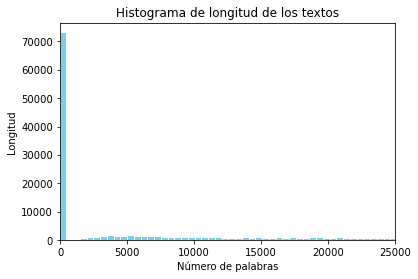

In [17]:
plt.hist(largo,bins=500,  color='#7dd0e3', rwidth=0.85)
plt.title('Histograma de longitud de los textos')
plt.xlabel('Número de palabras')
plt.ylabel('Longitud')
plt.xlim(0,25000)
plt.show() 

In [18]:
data=data.reset_index()

In [19]:
#longitud de los abstracts
largo_=[]
for i in range(0,52000):
    largo_.append(len(str(data['abstract'][i])))

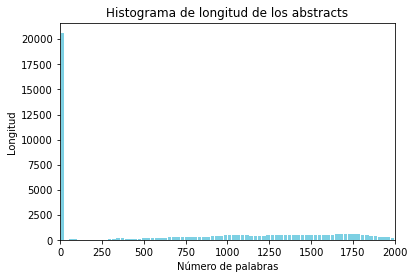

In [21]:
plt.hist(largo_,bins=500,  color='#7dd0e3', rwidth=0.85)
plt.title('Histograma de longitud de los abstracts')
plt.xlabel('Número de palabras')
plt.ylabel('Longitud')
plt.xlim(0,2000)
plt.show() 

A partir de aquí se realiza la misma tarea para cada técnica.

### TF-IDF texto completo

In [22]:
#definimos las stop words
stop_words = set(stopwords.words("english"))
##Creamos una lista de stopwords customizadas
new_words = ["ha", "become", "put", "large", "also", "since", "one", "two", "new", "previously", "shown","ng","background","describe","recent","despite","wa","objective"]
stop_words = stop_words.union(new_words)

In [23]:
#creamos el corpus con los artículos pre procesados
corpus = []
for i in range(0, 1000):
    #Eliminamos las  puntuaciones
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    #Convertimos a minusculas
    text = text.lower()
    
    #eliminamos tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # eliminamos caracteres especiales o dígitos
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    ##Eliminamos las stop words
    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
     #Lematización
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
    text2 = " ".join(text2)
    corpus.append(text2)

In [24]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [25]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)# obtenemos los nombres de las caracteristicas 
feature_names=cv.get_feature_names()

In [26]:
#Función para ordenar tf_idf en orden descendente
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # indice de la palabra y métrica tf-idf 
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #creacion de tuplas de características, métrica 
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [27]:
#extracción de keywords
keystf_0=[]
for i in range(0, 1000):
    
    doc=corpus[i]
 
    #generar tf-idf para los docuemntos
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#ordenar los vectores tf-idf  en orden descendente de metrica
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extraer solammente el top n; aqui es 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    keystf_0.append(keywords)

In [28]:
#convertimos al formato que queremos el resultado que nos ha devuelto la matriz
keystf_1=[]
for i in keystf_0:
    k1=list(i)
    keystf_1.append(k1)
keystf = []
for i in range(0,1000):
    #Remove punctuations-
    text = re.sub('[^a-zA-Z]', ' ', str(keystf_1[i]))
    ##Convert to list from string
    text = text.split()
    keystf.append(text)

In [29]:
#convertimos al mismo formato las palabras dadas por los autores
keys2=[]
for i in range(0, 1000):
    k=datax['keywords'][i]
    keys2.append(k)
keys3=[]
for i in range(0, 1000):    
    k3=str(keys2[i]).split(';')
    keys3.append(k3)
keys4 = []
for i in range(0, 1000):
    text = re.sub('[^a-zA-Z]', ' ', str(keys3[i]))
    
    text = text.split()
    
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    keys4.append(text)

In [30]:
#funcion que devuelve las métricas
def evaluate_keywords(proposed,groundtruth):

    proposed_set = set(proposed)
    true_set = set(groundtruth)
    true_positives = len(proposed_set.intersection(true_set))
    if len(proposed_set)==0:
        precision = 0
    else:
        precision = true_positives/float(len(proposed)) 
        jaccard= float(len(proposed_set.intersection(true_set)) / len(proposed_set.union(true_set)))

    if len(true_set)==0:
        recall = 0
    else:
        recall = true_positives/float(len(true_set))

    if precision + recall > 0:
        f1 = 2*precision*recall/float(precision + recall)
    else:
        f1 = 0
        

    return (precision, recall, f1, jaccard)

In [31]:
d=['s1_1','s2_1','s3_1','s4_1','s5_1','s6_1','s7_1','s8_1','s9_1','s10_1']

In [32]:
a=[]
al1=[]
al2=[]
al3=[]
al4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keystf[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    al1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    al2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    al3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    al4.append(aa4)


In [33]:
print(keystf[0])

['antibody', 'cell', 'macrophage', 'inhibitor', 'cytokine', 'cov', 'patient', 'sars', 'cross', 'severe']


In [34]:
print(keys4[5])

['covid', 'pythagorean', 'mean', 'global', 'health', 'security', 'risk', 'numerical', 'ranking', 'ordinal', 'ranking', 'pandemic', 'risk', 'management']


In [35]:
datax['keywords'][5]

'covid-19;pythagorean means;global health security risk;numerical rankings;ordinal rankings;pandemic;risk management'

In [36]:
print(al1)
print(al2)
print(al3)
print(al4)


[0.365, 0.3265, 0.291, 0.26475, 0.24620000000000006, 0.2345, 0.22314285714285712, 0.21264285714285713, 0.20036507936507938, 0.19124285714285716]
[0.048139675459671426, 0.08400640280697153, 0.11224320664995555, 0.13394241420120237, 0.15464771599721627, 0.17573739074025788, 0.19489344995452143, 0.21129827868272474, 0.2231213630694971, 0.23529127181572163]
[0.08374541310436076, 0.13039613137518644, 0.15715297060841676, 0.17198438954198983, 0.18338099575780709, 0.1937599392099993, 0.20053320485876752, 0.2043603141084122, 0.2035866014099434, 0.2035516862366637]
[0.048139675459671426, 0.07741938605451203, 0.09542923363910201, 0.10589125797726859, 0.11435409814328851, 0.1218283085529295, 0.12682750987641658, 0.12968569025598792, 0.12930517129983543, 0.12991143999453744]


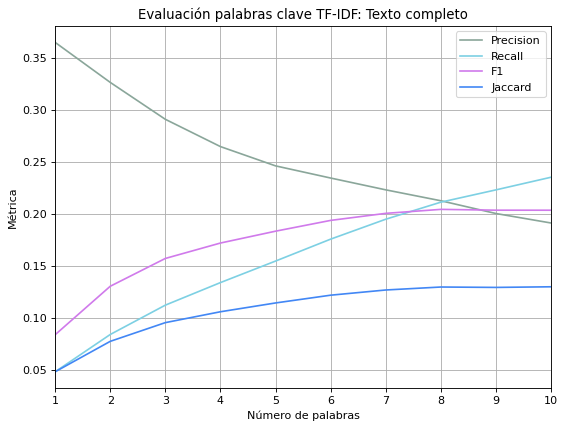

In [37]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,al1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,al2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,al3, 'b', label='F1',c='#d07aeb')
plt.plot(x,al4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF-IDF: Texto completo')
plt.show()

## Texto primeras 150 palabras - TF -IDF

In [38]:
corpus = []
for i in range(0, 1000):
    text = re.sub('[^a-zA-Z]', ' ', datax['testoss'][i])
    
    text = text.lower()
    
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    text=re.sub("(\\d|\\W)+"," ",text)
    
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [39]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [40]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)#feature_names=cv.get_feature_names()

In [41]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:
        
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [42]:
keys_t1=[]
for i in range(0, 1000):
    doc=corpus[i]
 
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
    sorted_items=sort_coo(tf_idf_vector.tocoo())
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    keys_t1.append(keywords)


In [43]:
keys_t2=[]
for i in keys_t1:
    k1=list(i)
    keys_t2.append(k1)
keys_t = []
for i in range(0,1000):
    text = re.sub('[^a-zA-Z]', ' ', str(keys_t2[i]))
    text = text.split()
    keys_t.append(text)

In [44]:
a=[]
am1=[]
am2=[]
am3=[]
am4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_t[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    am1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    am2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    am3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    am4.append(aa4)

In [45]:
print(keys_t[8])
print(keys4[8])

['respiratory', 'infectious', 'disease', 'virus', 'infectious', 'occurred', 'europe', 'sars', 'cov', 'cov', 'respiratory', 'tract', 'approximately']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [46]:
print(am1)
print(am2)
print(am3)
print(am4)

[0.36, 0.3065, 0.2626666666666666, 0.23525, 0.21600000000000003, 0.20206666666666667, 0.18613809523809519, 0.17469166666666666, 0.16478888888888893, 0.15746666666666667]
[0.04756885199853466, 0.07932928004085124, 0.10190544903010072, 0.1215276959610164, 0.1379114448102064, 0.1540496640621136, 0.16473767790012744, 0.17635682866032676, 0.1872007475467379, 0.19796091766557677]
[0.08284440399830095, 0.12321147955173617, 0.14264144683810626, 0.15508417230394622, 0.16265150582128696, 0.16871086196843793, 0.1685973846618806, 0.16919006196090827, 0.16898408554935326, 0.1691746464168768]
[0.04756885199853466, 0.07362805600860554, 0.08720456577494586, 0.09683707426927914, 0.10266165287981585, 0.10702201602665877, 0.10751297436150485, 0.10858552178918532, 0.1087894329282259, 0.10922228767644275]


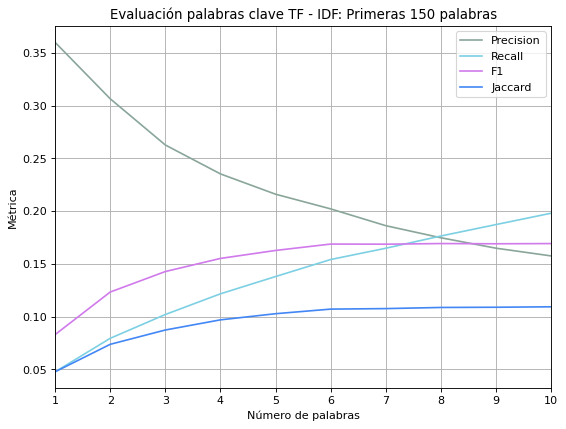

In [47]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,am1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,am2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,am3, 'b', label='F1',c='#d07aeb')
plt.plot(x,am4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Primeras 150 palabras')
plt.show()

In [48]:
datax['larg']=len(datax['abstract'])

In [49]:
datax.describe()

,larg
count,12777.0
mean,12777.0
std,0.0
min,12777.0
25%,12777.0
50%,12777.0
75%,12777.0
max,12777.0


In [50]:
long=[]
for i in range(0,12777):
    larg=len(datax['abstract'][i])
    long.append(larg)

In [51]:
np.mean(long)

1424.7000078265633

## TF-IDF Abstract

In [52]:
corpus = []
for i in range(0, 1000):
    text = re.sub('[^a-zA-Z]', ' ', datax['abstract'][i])
    
    text = text.lower()
    
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    text=re.sub("(\\d|\\W)+"," ",text)
    
    text = text.split()
    tagged = nltk.pos_tag(text)

    x1 = [(i,j.replace('VBD','r').replace('NNS','n').replace('NN','n').replace('JJ','a').replace('VB','v').replace('vP','v').replace('vN','v').replace('IN','n').replace('RB','a').replace('DT','n').replace('MD','v').replace('aR','n').replace('CC','n').replace('vG','v').replace('TO','n').replace('vZ','v').replace('CD','n').replace('aS','r').replace('W','n').replace('PRP','n').replace('EX','n').replace('Fn','n').replace('nP','n').replace('RP','n').replace('na','n').replace('Pn','n').replace('n$','n').replace('nn','n').replace('nS','n').replace('UH','n').replace('$','n').replace('POS','n').replace('SYM','n').replace('','n').replace('nnn','n').replace('nan','n').replace('nvn','n').replace('nrn','n').replace("n'n'n",'n')) for i,j in tagged]

    text1=[]
    for word in text:
        if word not in stop_words:
            text1.append(word)
    lem = WordNetLemmatizer()
    text2 = []
    for word in text1:
        if word not in stop_words:
            text2.append(lem.lemmatize(word, pos=x1[text.index(word)][1]))
    text2=text2[:150]
    text2 = " ".join(text2)
    corpus.append(text2)

In [53]:
cv=CountVectorizer(max_df=0.85,stop_words=stop_words, max_features=1000, ngram_range=(1,3))
X=cv.fit_transform(corpus)

In [54]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
feature_names=cv.get_feature_names()

In [55]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    for idx, score in sorted_items:
        
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [56]:
keys_a1=[]
for i in range(0, 1000):
    doc=corpus[i]
 
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))#sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())#extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    keys_a1.append(keywords)

In [57]:
keys_a2=[]
for i in keys_a1:
    k1=list(i)
    keys_a2.append(k1)
keys_a = []
for i in range(0,1000):
    text = re.sub('[^a-zA-Z]', ' ', str(keys_a2[i]))
    text = text.split()
    keys_a.append(text)

In [58]:
a=[]
an1=[]
an2=[]
an3=[]
an4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=keys_a[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    an1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    an2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    an3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    an4.append(aa4)

In [59]:
print(keys_a[666])
print(keys4[666])

['cancer', 'death', 'median', 'service', 'people', 'peak', 'direct', 'urgent', 'week', 'care']
['covid', 'health', 'informatics', 'oncology']


In [60]:
print(an1)
print(an2)
print(an3)
print(an4)

[0.378, 0.335, 0.30133333333333334, 0.2755, 0.254, 0.2368333333333333, 0.2248571428571428, 0.2115, 0.20144444444444445, 0.19110000000000002]
[0.05008635662869409, 0.08661727993580531, 0.11411100101950317, 0.1379510125717051, 0.1577579594217247, 0.17641351822405965, 0.19433017933424618, 0.20818697312954615, 0.22176601424666775, 0.23351159746032374]
[0.0869309520241254, 0.1341412188682402, 0.16073855350749, 0.17791174545096583, 0.18805074477264833, 0.1950786638495656, 0.20084160217175856, 0.20214293085270174, 0.20343675063822692, 0.2026284901436981]
[0.05008635662869409, 0.07986616779587581, 0.09725500584214267, 0.10903562403082447, 0.11663162495556843, 0.12284763005462795, 0.12721058081415737, 0.12870558195658122, 0.1297575077245999, 0.1289484032075766]


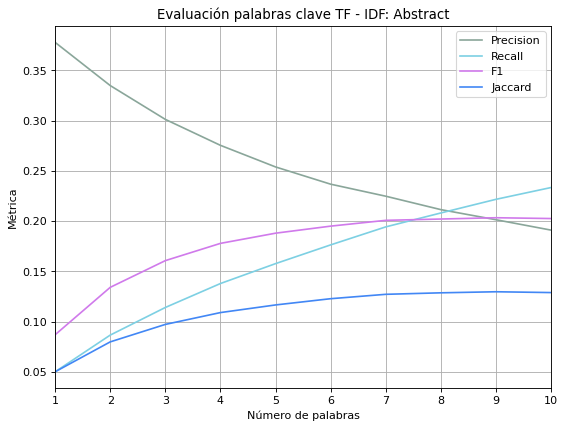

In [61]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,an1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,an2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,an3, 'b', label='F1',c='#d07aeb')
plt.plot(x,an4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave TF - IDF: Abstract')
plt.show()

### Entrenamiento propio modelo

Vamos a entrenar el propio modelo, luego utilizaremos los dos pre entrenados, cada uno con cada conjunto de datos.

In [62]:
# Funcion para convertiir un documento en una lista de tokens
def text_to_wordlist(text, remove_stopwords=False):
    review_text = re.sub("[^a-zA-Z]", " ", text)

    words = review_text.lower().split()

    return (words)


In [63]:
tokenizer = sent_tokenize
from nltk.tokenize import sent_tokenize

In [64]:
def text_to_sentences(text, tokenizer, remove_stopwords=False):
    # Funcion para convertir el texto en frases.
    # Devuelve una lista de frases y cada una de ellas es una lisat de palabras.
    
    raw_sentences = nltk.sent_tokenize(text) # this gives us a list of sentences
    sentences = []
    for sentence in raw_sentences:
        if len(sentence) > 0:
            sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

    return sentences

In [65]:
sentences = []
#devolvemos las frases
for i in range(0,12777):
    raw_sentences = nltk.sent_tokenize(datax['testoss'][i])
    for sentence in raw_sentences:
        sentences.append(text_to_wordlist(sentence, remove_stopwords=False))

In [66]:
num_features = 150
model = word2vec.Word2Vec(sentences, window=10, min_count=2,)
model_name = "w2v"
model.save(model_name)


In [67]:
model = word2vec.Word2Vec.load(model_name)

### Extracción de palabras clave: Texto completo

In [68]:
#funciion que transforma en lista de palabras
def text_to_wordlist(text, remove_stopwords=True):
    review_text = re.sub("[^a-zA-Z]", " ", text)

    words = review_text.lower().split()
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    return (meaningful_words)

In [69]:
#funcion que devuelve los vectores
def get_feature_vec(words, model):
    index2word_set = set(model.wv.index_to_key )
    clean_text = []
    for word in words:
        if word in index2word_set:
            clean_text.append(model.wv[word])

    return clean_text

In [70]:
#función para devolver el ranking
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [71]:
key_word_list_m=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_m.append(keywords_list)

In [72]:
a=[]
as1=[]
as2=[]
as3=[]
as4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_m[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    as1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    as2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    as3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    as4.append(aa4)

In [73]:
print(key_word_list_m[8])
print(keys4[8])

['ch', 'nasal', 'retrospective', 'respiratory', 'cov', 'like', 'respiratory', 'broad', 'basel', 'emergency']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [74]:
print(as1)
print(as2)
print(as3)
print(as4)


[0.086, 0.0835, 0.084, 0.0805, 0.08259999999999999, 0.08116666666666665, 0.08128571428571428, 0.080125, 0.07988888888888888, 0.07790000000000001]
[0.010334992149233635, 0.020843802783044266, 0.03107047209251914, 0.04021027246672354, 0.05172196547283201, 0.06194270712797769, 0.07172853071701334, 0.0811484805770948, 0.09087238718659334, 0.09849161877200138]
[0.01819912485175643, 0.03272637444255092, 0.04420857313647008, 0.05209620273827368, 0.061565945480213886, 0.06778826063977528, 0.0734999081109452, 0.07772178737462516, 0.08183546682692111, 0.08373162752905401]
[0.010334992149233635, 0.018521606536738115, 0.02487877740793342, 0.029225385607561636, 0.03471569624017113, 0.03824727550861317, 0.041543524639056154, 0.044035527845011045, 0.04633063026224671, 0.04724149331941274]


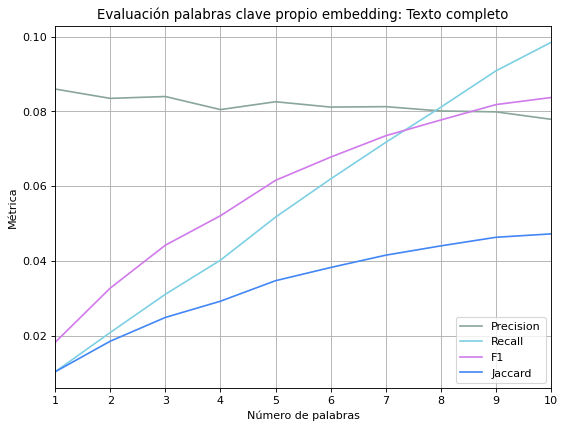

In [75]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,as1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,as2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,as3, 'b', label='F1',c='#d07aeb')
plt.plot(x,as4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio embedding: Texto completo')
plt.show()

## Propio embedding primeras 150 palabras

In [76]:
key_word_list_mm=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_mm.append(keywords_list)

In [77]:
print(key_word_list_mm[3])
print(key_word_list_m[3])

['kidney', 'confirmed', 'clinical', 'sars', 'china', 'il', 'crs', 'cytokine', 'beta', 'expressed']
['crrt', 'membrane', 'elevated', 'corticosteroids', 'outlined', 'ifn', 'suggests', 'dysfunction', 'shown', 'outcomes']


In [78]:
a=[]
amm1=[]
amm2=[]
amm3=[]
amm4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_mm[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    amm1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    amm2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    amm3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    amm4.append(aa4)

In [79]:
print(key_word_list_mm[8])
print(keys4[8])

['including', 'sars', 'pneumonia', 'approximately', 'since', 'late', 'third', 'across', 'syndrome', 'respiratory']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [80]:
print(amm1)
print(amm2)
print(amm3)
print(amm4)


[0.137, 0.132, 0.13166666666666665, 0.12675, 0.121, 0.1205, 0.11628571428571428, 0.1155, 0.11300000000000002, 0.11070000000000002]
[0.017440558116746028, 0.033875289646937916, 0.049868791254835815, 0.06400520057564915, 0.07684697536432795, 0.09173871258737325, 0.10248478334238362, 0.11634028996596299, 0.12837773893340423, 0.13902446922409736]
[0.0305559025871917, 0.052766116362586275, 0.07048084521444657, 0.08255905810262726, 0.09090485114783821, 0.10060229906654021, 0.10509115727875513, 0.11179273116389962, 0.11591106395729311, 0.11889687963393701]
[0.017440558116746028, 0.03037601789753939, 0.04050138884460193, 0.04736661297217505, 0.05221347515602641, 0.057982618299471135, 0.060769158332843305, 0.06476872130412135, 0.06737281213320984, 0.0692562911656527]


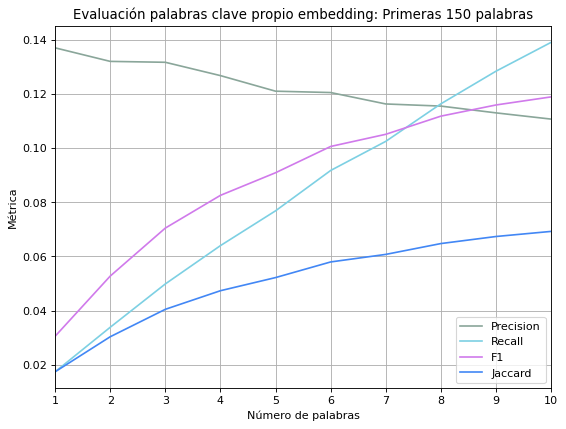

In [81]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,amm1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,amm2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,amm3, 'b', label='F1',c='#d07aeb')
plt.plot(x,amm4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio embedding: Primeras 150 palabras')
plt.show()

## Propio-embedding abstract

In [82]:
key_word_list_ma=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_ma.append(keywords_list)

In [83]:
a=[]
aj1=[]
aj2=[]
aj3=[]
aj4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_ma[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    aj1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    aj2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    aj3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    aj4.append(aa4)


In [84]:
print(key_word_list_ma[15])
print(keys4[15])

['arima', 'psnr', 'rmse', 'nrmse', 'model', 'lstm', 'narnn', 'nonlinear', 'mape', 'autoregression']
['arima', 'covid', 'forecasting', 'lstm', 'modeling', 'narnn']


In [85]:
print(aj1)
print(aj2)
print(aj3)
print(aj4)

[0.162, 0.155, 0.154, 0.1515, 0.14759999999999998, 0.1433333333333333, 0.14228571428571427, 0.135875, 0.13533333333333333, 0.13290000000000002]
[0.02120499893982866, 0.038916817577099916, 0.05671540171495246, 0.07447396720558823, 0.09000746873158201, 0.10487898455236253, 0.12219172758848018, 0.13314887354709673, 0.14924174207347918, 0.1635534441141286]
[0.03692752825137687, 0.060708161039615474, 0.08046609212253379, 0.09631308904732182, 0.10770322421650083, 0.11666566048967983, 0.12655738693699098, 0.12945561407182016, 0.13653387425837846, 0.14113036648941843]
[0.02120499893982866, 0.034842492782665206, 0.04611089837035665, 0.05567280861788916, 0.062599702809679, 0.06826528861233729, 0.07439031004690642, 0.07636551173814712, 0.08090215542177011, 0.0837602545823166]


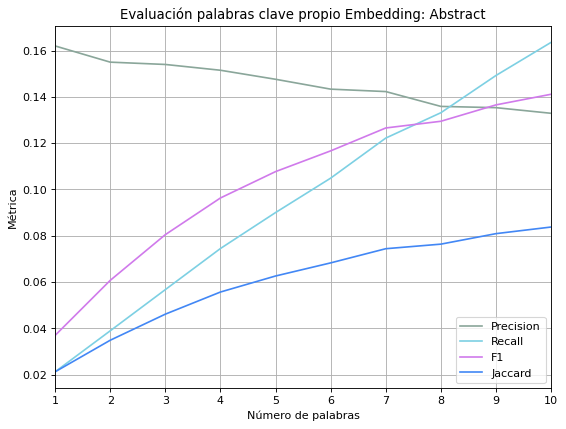

In [86]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,aj1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,aj2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,aj3, 'b', label='F1',c='#d07aeb')
plt.plot(x,aj4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave propio Embedding: Abstract')
plt.show()

### Modelo médico - Abstracts

In [87]:
def text_to_wordlist(text, remove_stopwords=True):
    review_text = re.sub("[^a-zA-Z]", " ", text)

    words = review_text.lower().split()
    stops = stop_words
    words2=[]
    for word in words:
        words2.append(lem.lemmatize(word))
    meaningful_words = [w for w in words2 if not w in stops]
    return (meaningful_words)

In [88]:
def get_feature_vec(words, model):
    index2word_set = set(model.index_to_key )
    clean_text = []
    for word in words:
        if word in index2word_set:
            clean_text.append(model[word])

    return clean_text

In [89]:
def powerMethod(A, x0, m, iter):
    n = A.shape[1]

    delta = m * (np.array([1] * n, dtype='float64') / n)
    for i in range(iter):
        x0 = np.dot((1 - m), np.dot(A, x0)) + delta
    return x0

In [90]:
key_word_list_b=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_b.append(keywords_list)

In [91]:
a=[]
ac1=[]
ac2=[]
ac3=[]
ac4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_b[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ac1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ac2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ac3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ac4.append(aa4)


In [92]:
print(key_word_list_b[8])
print(keys4[8])

['using', 'nucleic', 'method', 'tested', 'positive', 'concordant', 'carvs', 'case', 'recommended', 'multiplex']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [93]:
print(ac1)
print(ac2)
print(ac3)
print(ac4)

[0.139, 0.132, 0.12966666666666665, 0.1305, 0.127, 0.12383333333333334, 0.12328571428571426, 0.122125, 0.12000000000000001, 0.11930000000000002]
[0.017399648695817425, 0.03196376183081662, 0.0470478218998612, 0.0635899540324345, 0.07688938644127094, 0.09037536794342893, 0.10481570976964535, 0.11924112211959331, 0.13241665432732366, 0.14725831679207807]
[0.030450676894484944, 0.05018508358387548, 0.06708058041358572, 0.08284857074968568, 0.09253527355293123, 0.10073776476741104, 0.10910640316047145, 0.11611414019575042, 0.12111731348686167, 0.12682113347230176]
[0.017399648695817425, 0.028473094321362715, 0.03802561059146825, 0.047276049251128785, 0.05287739169381229, 0.05773012336970687, 0.0627095920533636, 0.06710778367694963, 0.07022547240037946, 0.07382877934053664]


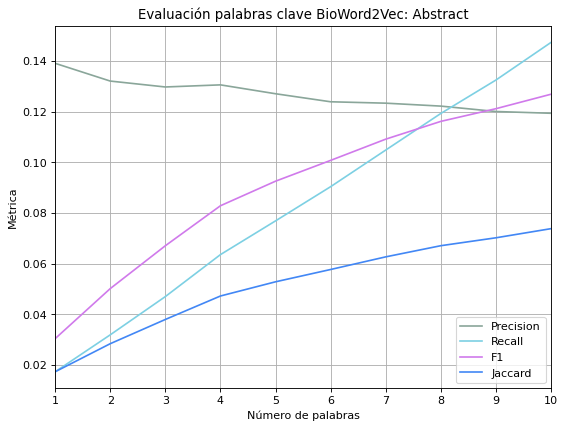

In [94]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ac1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ac2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ac3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ac4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Abstract')
plt.show()

## Modelo médico texto completo

In [95]:
key_word_list_bt=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_bt.append(keywords_list)

In [96]:
a=[]
ab1=[]
ab2=[]
ab3=[]
ab4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_bt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ab1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ab2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ab3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ab4.append(aa4)

In [97]:
print(key_word_list_bt[25])
print(keys4[25])

['hydroxychloroquine', 'due', 'limited', 'hematopoietic', 'treatment', 'developed', 'antiviral', 'developed', 'china', 'chemotherapy']
['covid', 'cancer', 'immunosuppression', 'transplant']


In [98]:
print(ab1)
print(ab2)
print(ab3)
print(ab4)

[0.146, 0.11, 0.09966666666666665, 0.09275, 0.08819999999999999, 0.08266666666666665, 0.07914285714285714, 0.07775, 0.07511111111111111, 0.0738]
[0.018668081388967445, 0.026902541678419992, 0.03722912938809594, 0.0460324218257924, 0.054727349936896985, 0.06229160820614751, 0.06970698767961522, 0.07814417955121113, 0.08458998641892201, 0.09273755869958253]
[0.0320396337253346, 0.041606315297638155, 0.05207737375530915, 0.05906524795148365, 0.06477080553807117, 0.06800233213774232, 0.07104649318245773, 0.0748053132048443, 0.0764657081236966, 0.0790186408201963]
[0.018668081388967445, 0.02360534824359589, 0.029359934163932913, 0.03337283163623832, 0.036631645592313626, 0.038401233101762536, 0.0401778497884284, 0.04243667793830057, 0.04333313952278174, 0.04481365334644198]


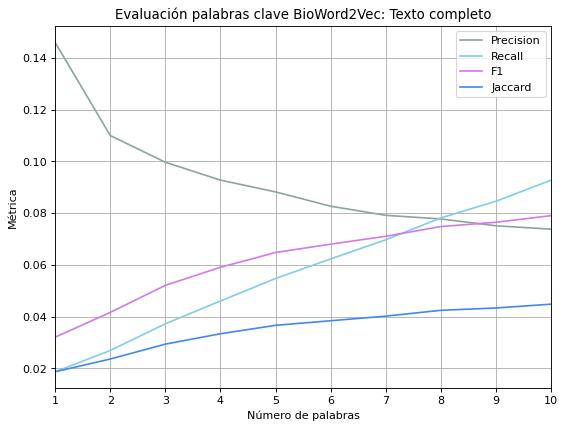

In [99]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ab1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ab2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ab3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ab4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Texto completo')
plt.show()

## Modelo médico primeras 150 palabras

In [100]:
key_word_list_btt=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text1=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text1:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_b)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1] 
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text1[words])
    key_word_list_btt.append(keywords_list)

In [101]:
a=[]
abb1=[]
abb2=[]
abb3=[]
abb4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_btt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    abb1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    abb2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    abb3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    abb4.append(aa4)

In [102]:
print(key_word_list_btt[8])
print(keys4[8])

['case', 'acquired', 'end', 'de', 'china', 'notably', 'july', 'world', 'emergence', 'sars']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [103]:
print(abb1)
print(abb2)
print(abb3)
print(abb4)

[0.091, 0.0925, 0.08766666666666666, 0.09175, 0.0904, 0.09416666666666666, 0.09457142857142856, 0.094875, 0.095, 0.09240000000000001]
[0.011080857115133264, 0.022886695617875787, 0.032428088375445016, 0.04608157457362935, 0.056733862868409916, 0.07040034032725176, 0.08297405254125034, 0.0942788234841018, 0.10563524843170319, 0.11356158351303054]
[0.019522590637703282, 0.036001437769317024, 0.046179712999173415, 0.059580412897701905, 0.06762822569034442, 0.07804117033188913, 0.08550304988777302, 0.09142064118785277, 0.09677047950157183, 0.09856312124418573]
[0.011080857115133264, 0.020492964891968585, 0.026276887448636675, 0.03415345280379413, 0.03867373072900836, 0.044601319797781966, 0.048858815106779675, 0.0523281635394701, 0.055577971321190675, 0.05662630640558621]


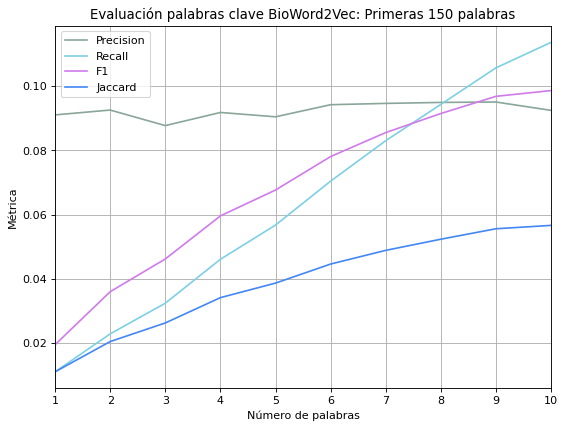

In [104]:
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,abb1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,abb2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,abb3, 'b', label='F1',c='#d07aeb')
plt.plot(x,abb4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave BioWord2Vec: Primeras 150 palabras')
plt.show()

## Modelo Google News abstract

In [105]:
key_word_list_g=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['abstract'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_g.append(keywords_list)

In [106]:
a=[]
ag1=[]
ag2=[]
ag3=[]
ag4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_g[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    ag1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    ag2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    ag3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    ag4.append(aa4)

In [107]:
print(key_word_list_g[8])
print(keys4[8])

['gene', 'acid', 'assay', 'coronavirus', 'positive', 'cov', 'e', 'acquired', 'gene', 'coronavirus']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [108]:
print(ag1)
print(ag2)
print(ag3)
print(ag4)

[0.15, 0.147, 0.146, 0.14225, 0.13860000000000003, 0.1365, 0.1374285714285714, 0.13625, 0.13422222222222221, 0.1322]
[0.018343138890805133, 0.03525343143623699, 0.052775060477989875, 0.06839258280699423, 0.08341314865755234, 0.09826244021921601, 0.11617758423699162, 0.13089278527617473, 0.14536587093234857, 0.15934317734981351]
[0.03223560895457021, 0.05561569265189874, 0.07541513857400277, 0.08960404181372886, 0.10069020918811412, 0.11035163844843034, 0.12143108738410242, 0.12873021670416138, 0.13450059780539464, 0.1391841017469986]
[0.018343138890805133, 0.03166749788133903, 0.04316991020297709, 0.051431753553290195, 0.05792394737868883, 0.06372837124745565, 0.07052510738484628, 0.07516932197777264, 0.07886527939140572, 0.08191778768458959]


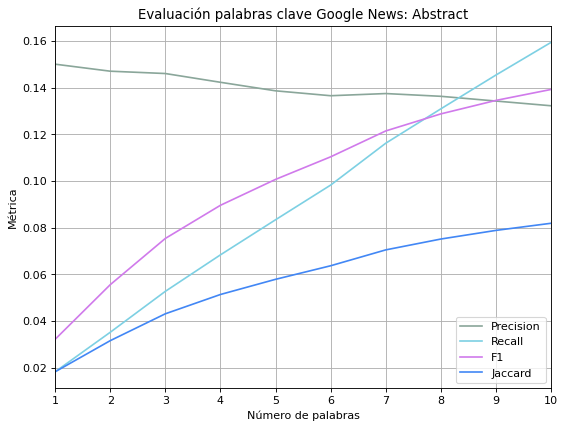

In [109]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,ag1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,ag2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,ag3, 'b', label='F1',c='#d07aeb')
plt.plot(x,ag4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Abstract')
plt.show()

## Google News texto completo

In [110]:
key_word_list_gt=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train = []
    for words in clean_train_text:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text[words])
 
    key_word_list_gt.append(keywords_list)

In [111]:
a=[]
agg1=[]
agg2=[]
agg3=[]
agg4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_gt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    agg1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    agg2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    agg3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    agg4.append(aa4)

In [112]:
print(key_word_list_gt[8])
print(keys4[8])

['delay', 'respiratory', 'immunocompetent', 'sars', 'rt', 'done', 'analysis', 'approximately', 'stage', 'statistical']
['covid', 'coinfection', 'multiplex', 'nucleic', 'acid', 'testing', 'respiratory', 'virus']


In [113]:
print(agg1)
print(agg2)
print(agg3)
print(agg4)

[0.071, 0.071, 0.07566666666666666, 0.07975, 0.08220000000000001, 0.08133333333333331, 0.0807142857142857, 0.08, 0.08066666666666668, 0.0796]
[0.00882716521524571, 0.01778748528733049, 0.028112856991649563, 0.039758515396711984, 0.05179161850361541, 0.061121598959176356, 0.07026083553958941, 0.07994776321459758, 0.09019978682663263, 0.09930973788348771]
[0.015500630625131274, 0.027815213219461773, 0.03985515245237953, 0.05147864398811431, 0.06129527111504688, 0.06721851031720058, 0.07235245381681657, 0.07696158332788966, 0.08198665126547804, 0.08511720352043671]
[0.00882716521524571, 0.015720467470349376, 0.022415327032582887, 0.02900053645901169, 0.03453159386471104, 0.0378739105578671, 0.040573390751767406, 0.04312550978383125, 0.04594776884505667, 0.047649708211515866]


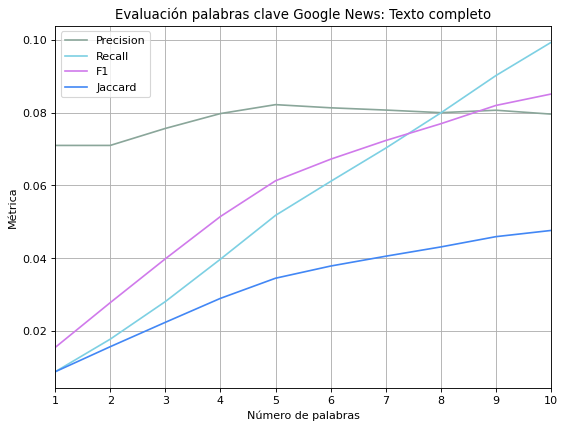

In [114]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,agg1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,agg2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,agg3, 'b', label='F1',c='#d07aeb')
plt.plot(x,agg4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Texto completo')
plt.show()

## Google News primeras 150 p.

In [115]:
key_word_list_gtt=[]
for i in range(0, 1000):
    clean_train_text = (text_to_wordlist(datax['testoss'][i], remove_stopwords=True))
    clean_train_text1=clean_train_text[:150]
    clean_train = []
    for words in clean_train_text1:
        if words in clean_train:
            words = +1
        else:
            clean_train.append(words)
    trainDataVecs = get_feature_vec(clean_train, model_g)
    trainData = np.asarray(trainDataVecs)
    similarity = np.dot(trainData, trainData.T)

    square_mag = np.diag(similarity)

    inv_square_mag = 1 / square_mag

    inv_square_mag[np.isinf(inv_square_mag)] = 0

    inv_mag= np.sqrt(inv_square_mag)

    cosine= similarity * inv_mag
    cosine = cosine.T * inv_mag
    
    n = cosine.shape[1]  # A is n x n
    m = 0.15
    x0 = [1] * n

    pagerank_values = powerMethod(cosine, x0, m, 130)

    srt = np.argsort(-pagerank_values)
    a = srt[0:10]
    keywords_list = []
    for words in a:
        keywords_list.append(clean_train_text1[words])
    key_word_list_gtt.append(keywords_list)

In [116]:
a=[]
agb1=[]
agb2=[]
agb3=[]
agb4=[]
for i in range(1,len(d)+1):
    key_word_list_loop=[]
    ev=[]
    for j in range(0,1000):
        lista=key_word_list_gtt[j][:i]
        e=evaluate_keywords(lista,keys4[j])
        ev.append(e)

    score_1=[item[0] for item in ev]
    aa1=np.mean(score_1)
    agb1.append(aa1)
    score_2=[item[1] for item in ev]
    aa2=np.mean(score_2)
    agb2.append(aa2)
    score_3=[item[2] for item in ev]
    aa3=np.mean(score_3)
    agb3.append(aa3)
    score_4=[item[3] for item in ev]
    aa4=np.mean(score_4)
    agb4.append(aa4)

In [117]:
print(key_word_list_gtt[816])
print(keys4[816])

['oriented', 'closing', 'italy', 'population', 'curve', 'transport', 'time', 'spain', 'decrease', 'became']
['lockdown', 'ozone', 'particulate', 'matter', 'sars', 'cov']


In [118]:
print(agb1)
print(agb2)
print(agb3)
print(agb4)

[0.154, 0.1475, 0.14433333333333334, 0.14175, 0.138, 0.13616666666666666, 0.13385714285714284, 0.13, 0.12855555555555553, 0.12630000000000002]
[0.020106791510003583, 0.03680122875060955, 0.05436833594681892, 0.07167741785648132, 0.08647113310665941, 0.10264550568970074, 0.11728818339165457, 0.1304405897908371, 0.14409302699856444, 0.1578728104504067]
[0.03495492943652948, 0.057515642961269896, 0.07658216552632988, 0.09186321886374045, 0.1024276200277173, 0.11277606794616248, 0.12033079961515858, 0.12532421013132494, 0.13071646760250036, 0.13501980753366752]
[0.020106791510003583, 0.03292882587880746, 0.04395762563544284, 0.05298172044322573, 0.05913194585712028, 0.06518128647345359, 0.0700526497984524, 0.07304691303928887, 0.07654787395656851, 0.07918767085765524]


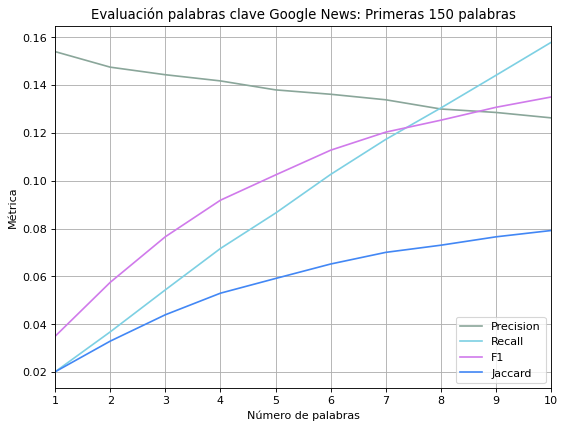

In [119]:
plt.figure(num=None, figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
plt.plot(x,agb1, 'b', label='Precision',c='#8aa69a')
plt.plot(x,agb2, 'b', label='Recall',c='#7dd0e3')
plt.plot(x,agb3, 'b', label='F1',c='#d07aeb')
plt.plot(x,agb4, 'b', label='Jaccard', c='#4287f5')
plt.grid(True)
plt.xlim(1,10)
plt.xlabel('Número de palabras')
plt.ylabel('Métrica')
plt.legend()
plt.title('Evaluación palabras clave Google News: Primeras 150 palabras')
plt.show()